# **Modèle de scoring**

**Objectif :**
- sélectionner et évaluer des modèles de classification avec gestion du déséquilibre des classes et minimisation d'un coût métier 

In [3]:
import os
import imblearn
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, 
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import time
import joblib
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import auc



# Version display
print("Versions utilisées :")
print(f"Python        : {os.sys.version.split()[0]}")
print(f"Numpy         : {np.__version__}")
print(f"Pandas        : {pd.__version__}")
print(f"Imblearn      : {imblearn.__version__}")
print(f"Matplotlib    : {plt.matplotlib.__version__}")

C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versions utilisées :
Python        : 3.10.16
Numpy         : 2.2.5
Pandas        : 2.2.3
Imblearn      : 0.13.0
Matplotlib    : 3.10.1


In [4]:
df_train = pd.read_csv('app_train_filtered_final.csv')
df_test = pd.read_csv('app_test_filtered_final.csv')

In [5]:
display(df_train.shape)
display(df_train.head())

(307507, 75)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,True,False,False,False,False,False,1
1,100003,1,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,False,True,False,0
2,100004,0,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,True,False,False,False,False,False,0
3,100006,1,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,True,False,False,False,False,False,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,True,False,0


In [6]:
display(df_test.shape)
display(df_test.head())

(48744, 74)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,SECTOR_Construction,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other
0,100001,1,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,False,False,False,False,False,False,False,False,False,True
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,False,False,False,True,True,False,False,False,False,False
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,False,False,False,False,True,False,False,False,False,False
3,100028,1,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,False,False,False,False,False,True,False,False,False,False
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,False,False,False,False,False,False,False,False,False,True


## **Nettoyage et normalisation**

In [8]:
display(df_train.dtypes)

SK_ID_CURR                    int64
CODE_GENDER                   int64
FLAG_OWN_CAR                  int64
FLAG_OWN_REALTY               int64
CNT_CHILDREN                  int64
                              ...  
OCCUPATION_Medical_Staff       bool
OCCUPATION_Security            bool
OCCUPATION_Management_Core     bool
OCCUPATION_Other               bool
TARGET                        int64
Length: 75, dtype: object

In [9]:
pd.set_option('display.max_rows', None) 

# Vérifier les valeurs infinies et manquantes dans df_train
print("Vérification des valeurs manquantes et infinies dans df_train:")
print("NaN présents :")
print(df_train.isnull().mean())
print("Valeurs infinies présentes :")
print(np.isinf(df_train).mean())

# Remplacer les valeurs infinies par NaN
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Appliquer l'imputation (par exemple, remplacer les NaN par la médiane)
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur df_train
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

# Vérifier à nouveau les NaN et les infinies
print("\nAprès imputation :")
print(df_train_imputed.isnull().sum())
print(np.isinf(df_train_imputed).sum())


# Vérifier les valeurs infinies et manquantes dans df_train
print("Vérification des valeurs manquantes et infinies dans df_test:")
print("NaN présents :")
print(df_test.isnull().mean())
print("Valeurs infinies présentes :")
print(np.isinf(df_test).mean())

# Remplacer les valeurs infinies par NaN
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Appliquer l'imputation (par exemple, remplacer les NaN par la médiane)
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur df_train
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

# Vérifier à nouveau les NaN et les infinies
print("\nAprès imputation :")
print(df_test_imputed.isnull().sum())
print(np.isinf(df_test_imputed).sum())



Vérification des valeurs manquantes et infinies dans df_train:
NaN présents :
SK_ID_CURR                                           0.000000
CODE_GENDER                                          0.000000
FLAG_OWN_CAR                                         0.000000
FLAG_OWN_REALTY                                      0.000000
CNT_CHILDREN                                         0.000000
AMT_INCOME_TOTAL                                     0.000000
AMT_CREDIT                                           0.000000
AMT_ANNUITY                                          0.000000
AMT_GOODS_PRICE                                      0.000000
REGION_POPULATION_RELATIVE                           0.000000
CNT_FAM_MEMBERS                                      0.000000
REGION_RATING_CLIENT_W_CITY                          0.000000
EXT_SOURCE_1                                         0.000000
EXT_SOURCE_2                                         0.000000
EXT_SOURCE_3                                         0

In [10]:
display(df_train.columns.tolist())

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BUILD_AVG',
 'TOTALAREA_MODE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'IS_UNEMPLOYED',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'PREV_AMT_APPLICATION_MEAN',
 'PREV_APP_CREDIT_PERC_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'POS_SK_DPD_MEAN',
 'POS_SK_DPD_DEF_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_PAYMENT_DIFF_MAX',
 'INSTAL_DPD_MEAN',
 'CC_AMT_BALANCE_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
 'CC_SK_DPD_MAX',
 'DAYS_EMPLOYED_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'CREDIT_TERM',
 'AGE',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_INCOME_TYPE_Commercial associa

## **Déséquilibre des classes**

In [20]:
df_train_imputed['TARGET'].value_counts()

TARGET
0.0    282682
1.0     24825
Name: count, dtype: int64

0 : bons clients
1: mauvais clients

faux négatif: FN - mauvais client prédit bon client, crédit accordé et perte en capital
faux positif: FP - bon client prédit mauvais client, crédit refusé manque à gagner

**Rappel de la problématique :**

🟩Environ 92% des clients sont des "clients qui remboursent. En apprenant, le modèle va tout le temps prédire 0 puisque classe majoritaire. De plus, en terme de précision le modèle prédit toujours 0 il aura 92% d'accuracy ce qui est faux et problématique puisque le modèle n'arriverra pas à prédire les clients qui feront un défaut de paiement. 

🟧**De plus**, les clients "mauvais payeurs" mal détéctés (faux négatifs) ont un coût pour l'organisme de crédit beaucoup plus élevé qu'un faux positif. Un client "mauvais payeur" a qui ont accorde un crédit alors qu'il fera défaut coûte plus cher à l'organisme de crédit qu'un manque à gagner (client "bons payeurs" a qui ont n'accorde pas un crédit).

➡️**Méthode utilisée:**

💡 Utilisation de la technique de suréchantillonnage synthétiques des minorités (SMOTE)
- génère des données synthétiques pour la classe minoritaire.
- consiste à choisir aléatoirement un point de la classe minoritaire et à calculer les k plus proches voisins de ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.
- Inconvénient à prendre en compte: des exemples synthétiques sont créés sans tenir compte de la classe majoritaire, ce qui peut entraîner des exemples ambigus s’il existe un fort chevauchement entre les classes.
- SMOTE doit être utilisé en combinaison avec StratifiedKFold pour s'assurer que les proportions de classes sont respectées dans chaque fold, ce qui garantit que l'évaluation du modèle est fiable.
- 🔴SMOTE seulement sur les données d'entrainements et sur les folds d'entrainement pendant la cv pas sur la validation.🔴

💡 Utilisation de class_weighted en parallèle pour les modèles comme LogisticRegression, RF, Lightgbm etc.

💡 Utilisation de GridSearchCV et StratifiedKFold 

💡 Optimisation du seuil métier

💡 Métriques adaptées (ROC_AUC_score, precision, recall, f1_score, score métier)

In [22]:
# Exemple de SMOTE pour visualiser la différence de distribution de la TARGET 
df_train_final=df_train_imputed.copy()
df_test_final= df_test_imputed.copy()

# Diviser les données en train et test
X = df_train_final.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train_final['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Distribution avant SMOTE
print("Distribution de la target avant SMOTE :")
print(np.unique(y_train, return_counts=True))

# Appliquer SMOTE manuellement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Distribution après SMOTE
print("\nDistribution de la target après SMOTE :")
print(np.unique(y_train_smote, return_counts=True))

Distribution de la target avant SMOTE :
(array([0., 1.]), array([226145,  19860]))

Distribution de la target après SMOTE :
(array([0., 1.]), array([226145, 226145]))


## **Modèles de classification**

**Méthode utilisée**

1. Création des jeux de données (train 70%, test et val 30%)
2. Normalisation est appliquée uniquement pour les modèles sensibles aux échelles (Logistic Regression et Naive Bayes).
3. SMOTE est utilisé uniquement sur le jeu d'entraînement pour corriger le déséquilibre, mais hors pipeline, car inclus dans une grille rend le temps de calcul trop élevé.
4. Sélection de 3 modèles avec pondération automatique des classes (class_weight='balanced'): Logistic Regression, Naive Bayes, et RandomForest
5. Définition des grilles d'hyperparamètres pour chacun des modèles afin d'optimiser leurs performances.
6. GridSearchCV avec Cross-Validation: 3-fold Stratifié sur l'entraînement uniquement pour sélectionner les meilleurs hyperparamètres.
7. Évaluation sur Validation : calcul des principales métriques (f1, precision, recall, ROC AUC) sur des données jamais vues.
8. Optimisation du seuil de classification : recherche du meilleur seuil pour minimiser un coût métier (10×FN + 1×FP)
9. Comparaison finale : agrégation de toutes les métriques et sélection du modèle optimal pour prédiction sur les données de test.

In [26]:
# Identifier les features numériques continues
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS','CNT_CHILDREN',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'BURO_DAYS_CREDIT_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'BURO_CREDIT_DAY_OVERDUE_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_DAYS_DECISION_MIN', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_MAX',
    'INSTAL_DPD_MEAN', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'CC_SK_DPD_MAX', 'DAYS_EMPLOYED_PERC',
    'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_TERM', 'AGE']


In [28]:
# Modèles sans besoin de normaliser (LightGBM et RF)
X_base = df_train_final.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_final['TARGET']
X_test_base = df_test_final.drop(columns=['SK_ID_CURR'])

X_train_base, X_val_base, y_train_split, y_val_split = train_test_split(X_base, y, test_size=0.2, stratify=y, random_state=42)

print(f"🔹Shape X_train_base : {X_train_base.shape}")
print(f"🔹Shape X_val_base : {X_val_base.shape}")
print(f"🔹Shape y_train_split : {y_train_split.shape}")
print(f"🔹Shape y_val_split : {y_val_split.shape}")
print(f"🔹Shape de X_test_base: {X_test_base.shape}")

# Modèles qui ont besoin de normalisation (logisticregression et SVM)
scaler = StandardScaler()
scaler.fit(X_base[numerical_features])

X_scaled = X_base.copy()
X_scaled[numerical_features] = scaler.transform(X_scaled[numerical_features])

X_test_scaled = X_test_base.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])

X_train_scaled, X_val_scaled, y_train_split, y_val_split= train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(f"🔹Shape X_train_scaled : {X_train_scaled.shape}")
print(f"🔹Shape X_val_scaled : {X_val_scaled.shape}")
print(f"🔹Shape y_train_split : {y_train_split.shape}")
print(f"🔹Shape y_val_split : {y_val_split.shape}")
print(f"🔹Shape de X_test_scaled: {X_test_scaled.shape}")

🔹Shape X_train_base : (246005, 73)
🔹Shape X_val_base : (61502, 73)
🔹Shape y_train_split : (246005,)
🔹Shape y_val_split : (61502,)
🔹Shape de X_test_base: (48744, 73)
🔹Shape X_train_scaled : (246005, 73)
🔹Shape X_val_scaled : (61502, 73)
🔹Shape y_train_split : (246005,)
🔹Shape y_val_split : (61502,)
🔹Shape de X_test_scaled: (48744, 73)


**Courbe ROC**: représentation graphique utilisée pour évaluer la performance d’un modèle de classification, notamment dans les situations de classes déséquilibrées. Elle trace la relation entre les vrais positifs et les faux positifs à différents seuils de classification.
- Abcisses : Taux de faux positif -> mauvais client classé en bon client
- Ordonnées: Taux de vrai positif -> bons clients classé en bon (recall)

**AUC**: Aire sous la courbe, si = 1 classificateur parfait, si proche de 0.5 alors aléatoire.

### **Logistic Regression**

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📌 Régression logistique- Comparaison des métriques :
Seuil 0.5  ➤ F1=0.266, Precision=0.165, Recall=0.672, Coût=33110
Seuil optimal 0.50 ➤ F1=0.266, Precision=0.165, Recall=0.672, Coût=33110
🎯 Best threshold: 0.50 with minimal cost: 33110
Nombre d'observations prédites pour le seuil optimal 0.50:
0    41335
1    20167
Name: count, dtype: int64
✔️ Best CV ROC AUC : 0.7490
✔️ Best params : {'C': 0.5, 'penalty': 'l2'}
⏱️ Temps d'exécution : 1935.60 secondes


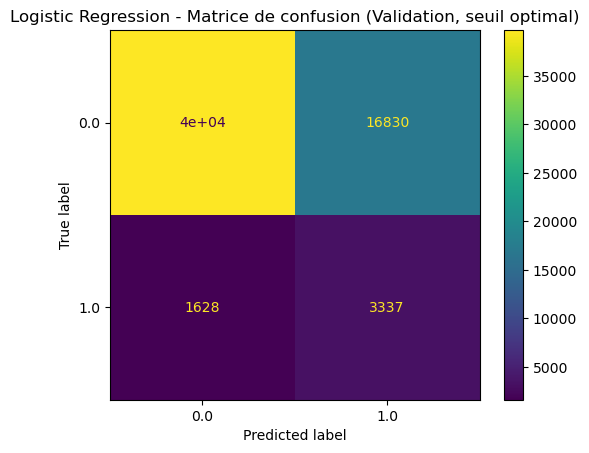

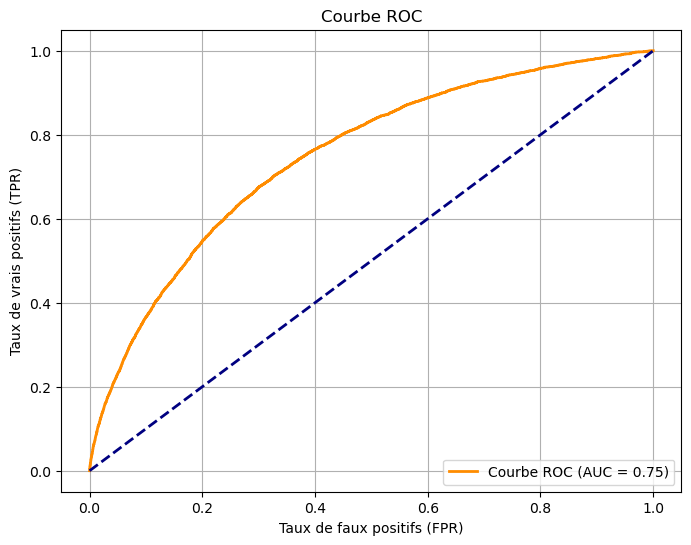

In [34]:

# Étape 1 : Appliquer SMOTE uniquement sur les données d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_split)

# Étape 2 : Définir la grille et la CV
model_name = 'Logistic Regression'
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logistic_model = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000, 
    solver='saga', 
    random_state=42
)

logistic_params = {
    'C': [0.1, 0.5],
    'penalty': ['l2']
}

grid_logistic = GridSearchCV(logistic_model, logistic_params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

# Étape 3 : Entraîner le modèle
start_time = time.time()
grid_logistic.fit(X_train_resampled, y_train_resampled)
execution_time = time.time() - start_time

# Étape 4 : Prédictions
y_val_prob = grid_logistic.predict_proba(X_val_scaled)[:, 1]
y_val_pred = grid_logistic.predict(X_val_scaled)

# ROC AUC
roc_auc = roc_auc_score(y_val_split, y_val_prob)

# Métriques seuil 0.5
y_pred_05 = (y_val_prob >= 0.5).astype(int)
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)

tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel()
cost_05 = 10 * fn + 1 * fp

# Recherche seuil optimal
best_threshold = 0.5
best_cost = cost_05

thresholds = np.arange(0.05, 1, 0.05)
for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold

# Métriques au seuil optimal
y_pred_opt = (y_val_prob >= best_threshold).astype(int)
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Résumé
# Résultats
print(f"\n📌 Régression logistique- Comparaison des métriques :")
print(f"Seuil 0.5  ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")

print(f"🎯 Best threshold: {best_threshold:.2f} with minimal cost: {best_cost}")
print(f"Nombre d'observations prédites pour le seuil optimal {best_threshold:.2f}:")
print(pd.Series(y_pred_opt).value_counts())
print(f"✔️ Best CV ROC AUC : {roc_auc:.4f}")
print(f"✔️ Best params : {grid_logistic.best_params_}")
print(f"⏱️ Temps d'exécution : {execution_time:.2f} secondes")

results_log = pd.DataFrame()

results_log = pd.concat([
    results_log,
    pd.DataFrame([{
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Seuil Optimal': best_threshold,
        'F1 Score (0.5)': f1_05,
        'Precision (0.5)': precision_05,
        'Recall (0.5)': recall_05,
        'Coût (0.5)': cost_05,
        'F1 Score (Opt)': f1_opt,
        'Precision (Opt)': precision_opt,
        'Recall (Opt)': recall_opt,
        'Coût (Opt)': best_cost,
        'Execution Time (s)': execution_time
    }])
], ignore_index=True)


# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("Logistic Regression - Matrice de confusion (Validation, seuil optimal)")
plt.show()

# Calcul des valeurs FPR et TPR à différents seuils
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_prob)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale (modèle aléatoire)
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### **Naive Bayes**


📌 Naive Bayes - Comparaison des métriques :
Seuil 0.5        ➤ F1=0.198, Precision=0.118, Recall=0.614, Coût=41986
Seuil optimal 0.85 ➤ F1=0.210, Precision=0.132, Recall=0.517, Coût=40924
🎯 Best threshold: 0.85 with minimal cost: 40924
Nombre d'observations prédites pour le seuil optimal 0.85:
0    42013
1    19489
Name: count, dtype: int64
✔️ Best CV ROC AUC : 0.6429
⏱️ Temps d'exécution : 0.81 secondes


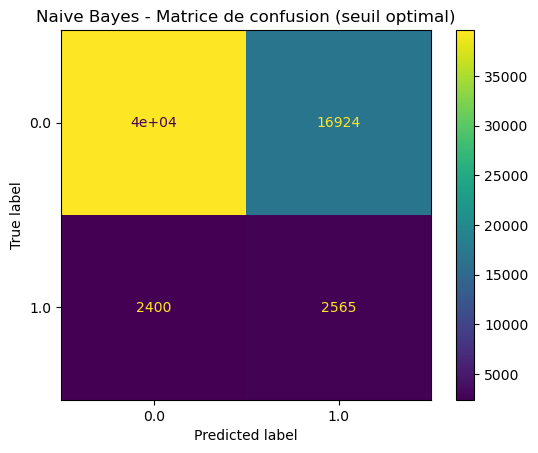

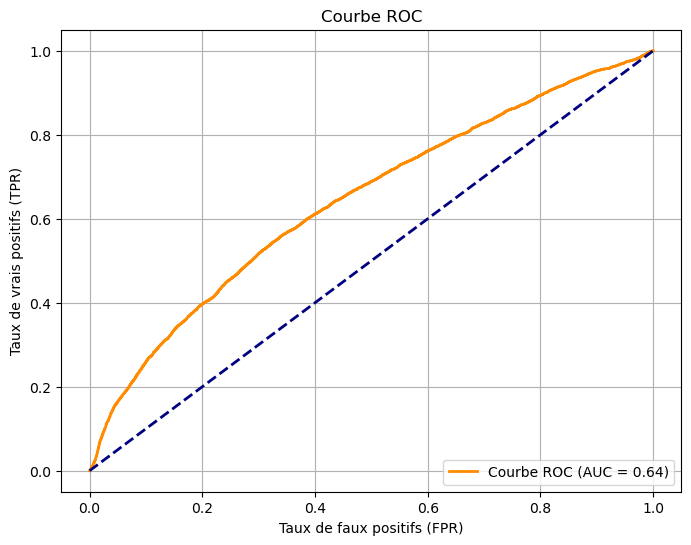

In [36]:
from sklearn.naive_bayes import GaussianNB

model_name = 'Naive Bayes (Gaussian)'

# SMOTE sur les données normalisées
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_split)

# Pas besoin de GridSearchCV ici, peu ou pas d’hyperparamètres
start_time = time.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_resampled, y_train_resampled)
execution_time = time.time() - start_time

# Prédictions
y_val_prob = gnb_model.predict_proba(X_val_scaled)[:, 1]
y_val_pred= gnb_model.predict(X_val_scaled)

roc_auc = roc_auc_score(y_val_split, y_val_prob)

y_pred_05 = (y_val_prob >= 0.5).astype(int)
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel()
cost_05 = 10 * fn + 1 * fp

# Seuil optimal
best_threshold = 0.5
best_cost = cost_05

thresholds = np.arange(0.05, 1, 0.05)
for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold

y_pred_opt = (y_val_prob >= best_threshold).astype(int)
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Résultats
print(f"\n📌 Naive Bayes - Comparaison des métriques :")
print(f"Seuil 0.5        ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")

print(f"🎯 Best threshold: {best_threshold:.2f} with minimal cost: {best_cost}")
print(f"Nombre d'observations prédites pour le seuil optimal {best_threshold:.2f}:")
print(pd.Series(y_pred_opt).value_counts())
print(f"✔️ Best CV ROC AUC : {roc_auc:.4f}")
print(f"⏱️ Temps d'exécution : {execution_time:.2f} secondes")

results_nb = pd.DataFrame()
results_nb = pd.concat([
    results_nb,
    pd.DataFrame([{
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Seuil Optimal': best_threshold,
        'F1 Score (0.5)': f1_05,
        'Precision (0.5)': precision_05,
        'Recall (0.5)': recall_05,
        'Coût (0.5)': cost_05,
        'F1 Score (Opt)': f1_opt,
        'Precision (Opt)': precision_opt,
        'Recall (Opt)': recall_opt,
        'Coût (Opt)': best_cost,
        'Execution Time (s)': execution_time
    }])
], ignore_index=True)

ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("Naive Bayes - Matrice de confusion (seuil optimal)")
plt.show()

# Calcul des valeurs FPR et TPR à différents seuils
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_prob)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale (modèle aléatoire)
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### **LightGBM**

Bayesian Optimization est une technique d'optimisation probabiliste qui permet d’optimiser les hyperparamètres d’un modèle de manière plus intelligente et efficace que les méthodes classiques comme GridSearchCV ou RandomSearchCV, en réduisant le nombre d'évaluations nécessaires, ce qui est particulièrement utile quand l’entraînement est long et coûteux.

Rappel: 

- target = 0 ➜ Bon client (=négatif car 0)
- target = 1 ➜ Mauvais client (= positif car 1)

| Prédit | Réalité | Nom de l’erreur    | Interprétation crédit                                                       |
|--------|---------|--------------------|------------------------------------------------------------------------------|
| 0      | 0       | Vrai négatif (TN)  | On prédit "bon client", il est bon ✔️                                        |
| 0      | 1       | Faux négatif (FN)  | ❌ On prédit "bon client", mais c’est un mauvais cli               X         |
| 1      | 0       | Faux positif (FP)  | ❌ On prédit "mauvais client", mais il est bon (perte d'opportunité)         |
| 1      | 1       | Vrai positif (TP)  | On prédit "mauvais client", il est mauvais ✔️                                |



⏱️ Temps d'exécution : 706.07 secondes
✔️ Best params ROC AUC : OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.11114350653481823), ('max_depth', 12), ('min_child_samples', 100), ('num_leaves', 150), ('reg_alpha', 1.0), ('reg_lambda', 1.0), ('scale_pos_weight', 1), ('subsample', 0.5)])
✔️ Best CV ROC AUC : 0.9797

📌 Comparaison des métriques :
Seuil 0.5        ➤ F1=0.062, Precision=0.570, Recall=0.033, Coût=48143
Seuil optimal 0.10 ➤ F1=0.295, Precision=0.192, Recall=0.642, Coût=31227

🎯 Best threshold: 0.10 with minimal cost: 31227
0    44857
1    16645
Name: count, dtype: int64


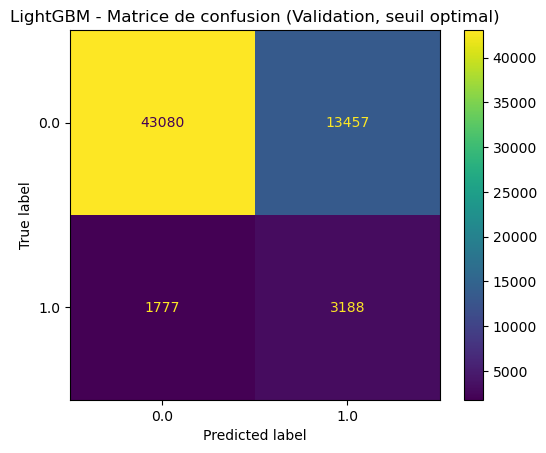

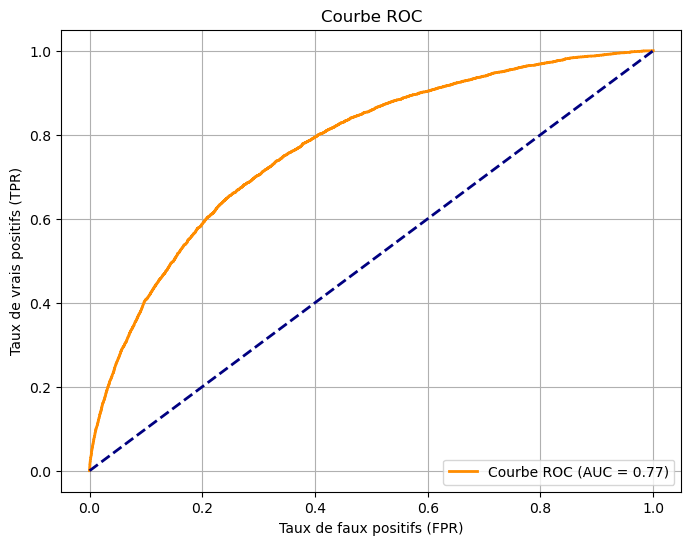

In [38]:

model_name = 'LightGBM'

# Rééchantillonnage avec SMOTE sur le jeu d'entraînement
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

# Initialisation du modèle LightGBM avec class_weight équilibré
lgbm_model = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

# Définir l'espace de recherche pour BayesSearchCV (optimisation sur le ROC AUC)
search_space_lgbm = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'num_leaves': Integer(15, 150),
    'max_depth': Integer(3, 12),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-3, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-3, 1.0, prior='log-uniform'),
    'scale_pos_weight': Integer(1, 20)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Optimisation bayésienne sur le ROC AUC
opt = BayesSearchCV(
    estimator=lgbm_model,
    search_spaces=search_space_lgbm,
    scoring='roc_auc',
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

start_time = time.time()
opt.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

# Prédictions avec le meilleur modèle
best_model = opt.best_estimator_
y_val_prob = best_model.predict_proba(X_val_base)[:, 1]  # Probabilités classe 1

# Évaluation initiale au seuil 0.5 (standard pour ROC AUC)
y_pred_05 = (y_val_prob >= 0.5).astype(int) # génère les prédictions au seuil de 0.5
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel() # ravel permet d'avoir une matrice de type tn, fp, fn, tp
cost_05 = 10 * fn + 1 * fp
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)

# Recherche du seuil optimal selon le coût métier
best_threshold = 0.5
best_cost = cost_05
thresholds = np.arange(0.05, 1.0, 0.05)

for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold

#  Métriques au seuil optimisé
y_pred_opt = (y_val_prob >= best_threshold).astype(int)
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Affichage des résultats intermédiaires
print(f"\n⏱️ Temps d'exécution : {execution_time:.2f} secondes")
print(f"✔️ Best params ROC AUC : {opt.best_params_}")
print(f"✔️ Best CV ROC AUC : {opt.best_score_:.4f}")
print(f"\n📌 Comparaison des métriques :")
print(f"Seuil 0.5        ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")
print(f"\n🎯 Best threshold: {best_threshold:.2f} with minimal cost: {best_cost}")
print(pd.Series(y_pred_opt).value_counts())

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("LightGBM - Matrice de confusion (Validation, seuil optimal)")
plt.show()

# Calcul des valeurs FPR et TPR à différents seuils
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_prob)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale (modèle aléatoire)
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Interprétation :**
- Seuil de 0.5:
Très faible rappel (3.3%) : le modèle laisse passer presque tous les mauvais clients (classe 1). Précision élevée artificiellement (57%) car le modèle ne prend presque aucun risque.
F1-score bas = équilibre médiocre entre rappel et précision. **Coût métier élevé : beaucoup de faux négatifs (FN).**

- Seuil optimal 0.10 (très strict)
En abaissant le seuil à 0.10, on sacrifie la précision (plus de faux positifs), mais on augmente drastiquement le rappel : on capte 64.2% des mauvais clients ! Le coût métier baisse de 35% par rapport au seuil 0.5. F1-score bien plus équilibré (0.295 vs 0.062), ce qui montre un meilleur compromis global.

- Maintenant nous allons tester BayesSearchCV en focntion du coût métier et non plus en fonction de ROC AUC 

✅ Nouveau coût : 31307
✅ Nouveau ROC AUC : 0.7712
✅ F1 score: 0.2941883026887185
✅ Precision: 0.19087584677177627
✅ Recall: 0.641289023162135


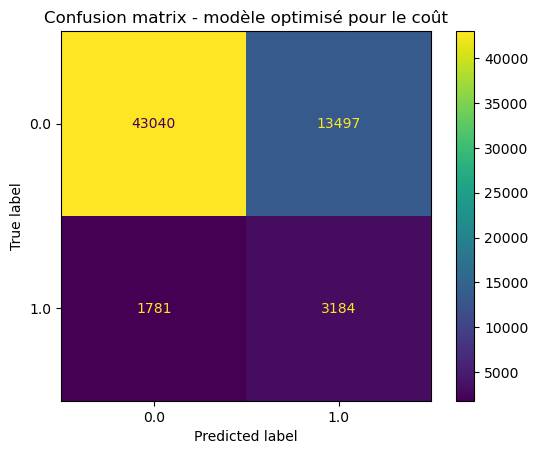

In [46]:
from sklearn.metrics import make_scorer

def cost_score_function(y_true, y_proba, threshold=0.10):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return -(10 * fn + 1 * fp)  # négatif pour que BayesSearchCV le maximise

def custom_cost_score(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return cost_score_function(y, y_proba, threshold=0.10)

cost_scorer = make_scorer(custom_cost_score, greater_is_better=True, needs_proba=True)

search_space_lgbm_cost = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'num_leaves': Integer(15, 150),
    'max_depth': Integer(3, 12),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-3, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-3, 1.0, prior='log-uniform'),
    'scale_pos_weight': Integer(1, 20)
}

opt_cost = BayesSearchCV(
    estimator=LGBMClassifier(objective='binary', class_weight='balanced', random_state=42, verbose=-1),
    search_spaces=search_space_lgbm_cost,
    scoring=custom_cost_score,
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=False
)

opt_cost.fit(X_train_smote, y_train_smote)

final_model_cost = opt_cost.best_estimator_
y_val_prob_cost = final_model_cost.predict_proba(X_val_base)[:, 1]
y_pred_cost = (y_val_prob_cost >= 0.10).astype(int)

tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_cost).ravel()
final_cost = 10 * fn + 1 * fp
roc_auc_final_cost = roc_auc_score(y_val_split, y_val_prob_cost)

print(f"✅ Nouveau coût : {final_cost}")
print(f"✅ Nouveau ROC AUC : {roc_auc_final_cost:.4f}")
print(f"✅ F1 score: {f1_score(y_val_split, y_pred_cost)}")
print(f"✅ Precision: {precision_score(y_val_split, y_pred_cost)}")
print(f"✅ Recall: {recall_score(y_val_split, y_pred_cost)}")

ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_cost)
plt.title("Confusion matrix - modèle optimisé pour le coût")
plt.show()



- Aucune amélioration supplémentaire du coût après réoptimisation : le modèle était déjà proche de l’optimum métier.
- ROC AUC chute de 0.9797 → 0.7718 : c'est attendu, car le modèle favorise la détection métier plutôt qu'un compromis global.
- Cela confirme que ROC AUC n’est pas toujours pertinent dans des contextes à coût asymétrique comme le crédit

### **Random Forest**

FN (Faux négatif) = Prédit bon client (0) alors que c'est un mauvais (1) → très coûteux

FP (Faux positif) = Prédit mauvais client (1) alors que c'est un bon (0) → perte opportunité

In [48]:
# Nom du modèle
model_name = 'Random Forest (Bayesian Opt)'

# Rééchantillonnage SMOTE sur les données de base
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

# Définir le modèle avec class_weight équilibré
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Définir l’espace de recherche
search_space_rf = {
    'n_estimators': Integer(100, 800),
    'max_depth': Integer(5, 30),
    'max_features': Categorical(['sqrt', 'log2', None])
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#  Optimisation bayésienne
opt_rf = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space_rf,
    scoring='roc_auc',
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

#  Entraînement avec chronométrage
start_time = time.time()
opt_rf.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

#  Prédictions sur la validation
best_model = opt_rf.best_estimator_
y_val_pred = best_model.predict(X_val_base)
y_val_prob = best_model.predict_proba(X_val_base)[:, 1]

# ROC AUC global (indépendant du seuil)
roc_auc = roc_auc_score(y_val_split, y_val_prob)

#  Seuil par défaut 0.5
y_pred_05 = (y_val_prob >= 0.5).astype(int)
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel()
cost_05 = 10 * fn + 1 * fp

# Recherche du seuil optimal selon le coût métier
best_threshold = 0.5
best_cost = cost_05
thresholds = np.arange(0.05, 1.0, 0.05)

for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold
        
#  Métriques au seuil optimal
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Affichage des résultats
print(f"\n⏱️ Temps d'exécution : {execution_time:.2f} secondes")
print(f"✔️ Best params : {opt_rf.best_params_}")
print(f"✔️ Best CV ROC AUC : {opt_rf.best_score_:.4f}")
print(f"ROC AUC (validation): {roc_auc_score(y_val_split, y_val_prob):.4f}")
print(f"\n📌 Comparaison des métriques :")
print(f"Seuil 0.5        ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")
print(f"🎯 Seuil optimal = {best_threshold:.2f} | Coût minimum = {best_cost}")
print(f"Nombre de prédictions positives (seuil {best_threshold:.2f}) :\n{pd.Series(y_pred_opt).value_counts()}")

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("Random Forest - Matrice de confusion (Validation, seuil optimal)")
plt.show()

# Calcul des valeurs FPR et TPR à différents seuils
fpr, tpr, thresholds = roc_curve(y_val_split, y_prob)

# Calcul des valeurs FPR et TPR à différents seuils
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_prob)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale (modèle aléatoire)
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
# Réoptimisation légère sur un paramètre métier sensible
# Exemple : max_depth (peut être test avec d'autres paramètres si besoin)

rf_reopt = BayesSearchCV(
    estimator=opt_rf.best_estimator_,
    search_spaces={'max_depth': Integer(5, 20)},
    scoring=cost_scorer,
    cv=cv,
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_reopt.fit(X_train_smote, y_train_smote)
final_model = rf_reopt.best_estimator_
Nouvelle prédiction + évaluation finale
y_val_prob_final = final_model.predict_proba(X_val_base)[:, 1]
y_pred_final = (y_val_prob_final >= best_threshold).astype(int)

final_roc_auc = roc_auc_score(y_val_split, y_val_prob_final)
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_final).ravel()
final_cost = 10 * fn + 1 * fp

print(f"\n📌 Après réoptimisation Random Forest sur coût métier :")
print(f"Coût final : {final_cost}")
print(f"ROC AUC final : {final_roc_auc:.4f} (vs initial {roc_auc:.4f})")
print(f"Seuil optimal retenu : {best_threshold:.2f}")
print(pd.Series(y_pred_final).value_counts())

ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_final)
plt.title("RandomForest - Matrice de confusion après re-opt (Validation, seuil optimal)")
plt.show()

# Stockage dans tableau global
model_name = "Random Forest"
results_rf= pd.DataFrame()
results_rf = pd.concat([
    results_rf,
    pd.DataFrame([{
        'Model': model_name + " (Cost Opt)",
        'ROC AUC': final_roc_auc,
        'Seuil Optimal': best_threshold,
        'F1 Score (0.5)': f1_05,
        'Precision (0.5)': precision_05,
        'Recall (0.5)': recall_05,
        'Coût (0.5)': cost_05,
        'F1 Score (Opt)': f1_opt,
        'Precision (Opt)': precision_opt,
        'Recall (Opt)': recall_opt,
        'Coût (Opt)': best_cost,
        'Coût (Final)': final_cost,
        'Execution Time (s)': execution_time
    }])
], ignore_index=True)


### **Gridsearchcv**

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18359
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0

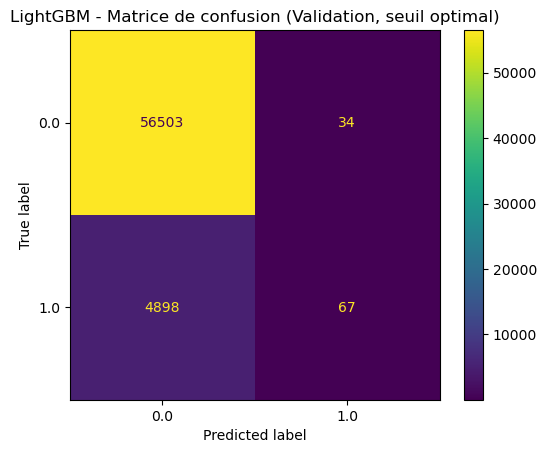

In [149]:
model_name = 'LightGBM'

X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

lgbm_model = LGBMClassifier(is_unbalanced = True, random_state=42)
params = {
    'scale_pos_weight': [20], # Param qui donne plus d'importance aux classes minoritaires
    'min_child_samples': [80], # Moins = arbre plus profond, favorise la classe minoritaire
    'max_depth': [8, 10],
    'learning_rate': [0.02],
    'subsample': [0.2, 0.9],
    'n_estimators': [100, 500]
}

grid_lgbm = GridSearchCV(lgbm_model, params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

start_time = time.time()
grid_lgbm.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

y_val_prob = grid_lgbm.predict_proba(X_val_base)[:, 1]
y_val_pred = grid_lightgbm.predict(X_val_base)

# ROC AUC : mesure globale, indépendante du seuil
roc_auc = roc_auc_score(y_val_split, y_val_prob)

# Métriques au seuil par défaut (0.5)
y_pred_05 = (y_val_prob >= 0.5).astype(int)
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)

# Coût métier à 0.5
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel()
cost_05 = 10 * fn + 1 * fp

# Recherche du meilleur seuil pour minimiser le coût métier
best_threshold = 0.5
best_cost = cost_05

thresholds = np.arange(0.05, 1, 0.05)

for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold

# Métriques au seuil optimisé
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Affichage comparatif

print(f"⏱️ Temps d'exécution : {execution_time:.2f} secondes")
print(f"✔️ Best params : {grid_lgbm.best_params_}")
print(f"✔️ Best CV ROC AUC : {grid_lgbm.best_score_:.4f}")
print(f"\n📌 Comparaison des métriques :")
print(f"Seuil 0.5        ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")

# Sauvegarde des résultats
results = pd.concat([
    results,
    pd.DataFrame([{
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Seuil Optimal': best_threshold,
        'F1 Score (0.5)': f1_05,
        'Precision (0.5)': precision_05,
        'Recall (0.5)': recall_05,
        'Coût (0.5)': cost_05,
        'F1 Score (Opt)': f1_opt,
        'Precision (Opt)': precision_opt,
        'Recall (Opt)': recall_opt,
        'Coût (Opt)': best_cost,
        'Execution Time (s)': execution_time
    }])
], ignore_index=True)


print(f"🎯 Best threshold: {best_threshold:.2f} with minimal cost: {best_cost}")
print(f"Nombre d'observations prédites pour le seuil optimal {best_threshold:.2f}:")
print(pd.Series(y_pred_opt).value_counts())

ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("LightGBM - Matrice de confusion (Validation, seuil optimal)")
plt.show()

In [143]:
model_name = 'Random Forest'

X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
params = {
    'n_estimators': [100, 500],
    'max_depth': [20, 50],
    'min_samples_split': [2, 10],
    'max_features': ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf_model, params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

start_time = time.time()
grid_rf.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

y_val_prob = grid_rf.predict_proba(X_val_base)[:, 1]
y_val_pred = grid_rf.predict(X_val_base)

# ROC AUC : mesure globale, indépendante du seuil
roc_auc = roc_auc_score(y_val_split, y_val_prob)

# Métriques au seuil par défaut (0.5)
y_pred_05 = (y_val_prob >= 0.5).astype(int)
f1_05 = f1_score(y_val_split, y_pred_05)
precision_05 = precision_score(y_val_split, y_pred_05)
recall_05 = recall_score(y_val_split, y_pred_05)

# Coût métier à 0.5
tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_05).ravel()
cost_05 = 10 * fn + 1 * fp

# Recherche du meilleur seuil pour minimiser le coût métier
best_threshold = 0.5
best_cost = cost_05

thresholds = np.arange(0.05, 1, 0.05)

for threshold in thresholds:
    y_pred_opt = (y_val_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val_split, y_pred_opt).ravel()
    cost = 10 * fn + 1 * fp
    if cost < best_cost:
        best_cost = cost
        best_threshold = threshold

# Métriques au seuil optimisé
f1_opt = f1_score(y_val_split, y_pred_opt)
precision_opt = precision_score(y_val_split, y_pred_opt)
recall_opt = recall_score(y_val_split, y_pred_opt)

# Affichage comparatif
print(f"⏱️ Temps d'exécution : {execution_time:.2f} secondes")
print(f"✔️ Best params : {grid_rf.best_params_}")
print(f"✔️ Best CV ROC AUC : {grid_rf.best_score_:.4f}")
print(f"\n📌 Comparaison des métriques :")
print(f"Seuil 0.5        ➤ F1={f1_05:.3f}, Precision={precision_05:.3f}, Recall={recall_05:.3f}, Coût={cost_05}")
print(f"Seuil optimal {best_threshold:.2f} ➤ F1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}, Coût={best_cost}")

# Sauvegarde des résultats
results = pd.concat([
    results,
    pd.DataFrame([{
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Seuil Optimal': best_threshold,
        'F1 Score (0.5)': f1_05,
        'Precision (0.5)': precision_05,
        'Recall (0.5)': recall_05,
        'Coût (0.5)': cost_05,
        'F1 Score (Opt)': f1_opt,
        'Precision (Opt)': precision_opt,
        'Recall (Opt)': recall_opt,
        'Coût (Opt)': best_cost,
        'Execution Time (s)': execution_time
    }])
], ignore_index=True)


print(f"🎯 Best threshold: {best_threshold:.2f} with minimal cost: {best_cost}")
print(f"Nombre d'observations prédites pour le seuil optimal {best_threshold:.2f}:")
print(pd.Series(y_pred_opt).value_counts())

ConfusionMatrixDisplay.from_predictions(y_val_split, y_pred_opt)
plt.title("RandomForest - Matrice de confusion (Validation, seuil optimal)")
plt.show()


Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

*1. Warning: LightGBM conseille de remplacer les espaces par des underscores _ dans les noms de colonnes.
 2. [LightGBM] [Info] Number of positive: 67842, number of negative: 226143: 67 842 positifs (classe 1), 226 143 négatifs (classe 0).
LightGBM utilise cette information pour équilibrer l'optimisation (surtout avec class_weight='balanced').
 3. LightGBM détecte automatiquement s'il est plus efficace d'utiliser : row-wise (traitement ligne par ligne) ou col-wise (colonne par colonne).
Ici il a choisi row-wise, aller un peu plus vite si forces force_row_wise=True, mais ce n'est pas obligatoire.
 4.[LightGBM] [Info] Total Bins 24434 : bins = regroupements :LightGBM fait des regroupements des variables en classes (bins) pour aller plus vite. Ici, il a créé 24 434 bins pour toutes les variables.*


**Rappel:**
- Positif (1)	Mauvais client (à refuser)
- Négatif (0)	Bon client (à accepter)
- Faux positif (FP)	Bon client classé à tort comme mauvais → crédit injustement refusé
- Faux négatif (FN)	Mauvais client classé à tort comme bon → crédit injustement accordé

**Avec GridSearchCV c'est le modèle LightGBM qui est sélectionné avec une ROC AUC score de 0.77, un coût de 39049 avec un seuil normal de 0.5 et lorsqu'on baisse le seuil à 0.25 on minimise le coût d'erreur de 30999.**

**Baisse du seuil pour être plus sensible : identifie plus de mauvais clients (positifs) même si on fait plus d'erreurs en refusant des bons clients.
Il vaut mieux refuser quelques bons clients par précaution plutôt que d'accorder des crédits à de mauvais payeurs, car ces derniers coûtent beaucoup plus cher à l’organisme de crédit**
Un seuil plus bas (0.25 au lieu de 0.5) signifie qu'on "accepte plus facilement" qu'un client soit considéré comme "à risque" (classe 1).
.
Globalement,ExtraTreesClassifier  et la régression logistique restent en retrait, notamment avec des scores ROC AUC respectivement de 0.32 et 060 ainsi que des coûts de pertes élevés.




## **Exécution sur tout le train et prédiction sur le test**

#### LightGBM

In [28]:
import pickle

# 1. Définir et entraîner le modèle LightGBM avec les meilleurs hyperparamètres
final_model = lgb.LGBMClassifier(
    learning_rate=0.05,
    max_depth=8,
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

# Entraînement sur tout le dataset d'entraînement (X, y)
final_model.fit(X, y)

# 2. Sauvegarde du modèle final
with open('final_model_lightgbm.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("✅ Modèle LightGBM final entraîné et sauvegardé.")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24823, number of negative: 282679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11952
[LightGBM] [Info] Number of data points in the train set: 307502, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
✅ Modèle LightGBM final entraîné et sauvegardé.


In [29]:
# 3. Prédictions de probabilités
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# 4. Application du seuil optimisé
threshold = 0.25
y_test_pred = (y_test_proba >= threshold).astype(int)

print("✅ Prédictions terminées avec seuil 0.25")


✅ Prédictions terminées avec seuil 0.25


Nombre de clients classés par le modèle :
1    31234
0    17510
Name: count, dtype: int64


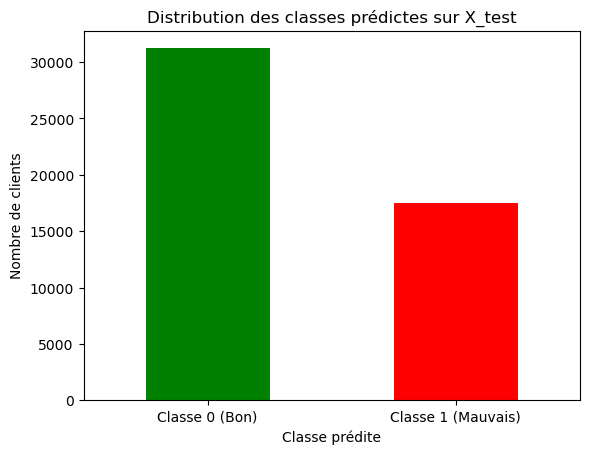

In [30]:
# Compter
counts = pd.Series(y_test_pred).value_counts()
print("Nombre de clients classés par le modèle :")
print(counts)

# Visualisation rapide
counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution des classes prédictes sur X_test')
plt.xlabel('Classe prédite')
plt.ylabel('Nombre de clients')
plt.xticks(ticks=[0, 1], labels=["Classe 0 (Bon)", "Classe 1 (Mauvais)"], rotation=0)
plt.show()

- Le modèle best_model_lightgbm.pkl  est un modèle entraîné sur un split (X_train_split) uniquement. (80%)
- Le modèle final_model_lightgbm.pkl sera donc plus fort et plus fiable car entraîné sur toutes les données d'entraînement. (100%)

#### RandomForest

Nombre de clients classés par le modèle :
1    24402
0    24342
Name: count, dtype: int64


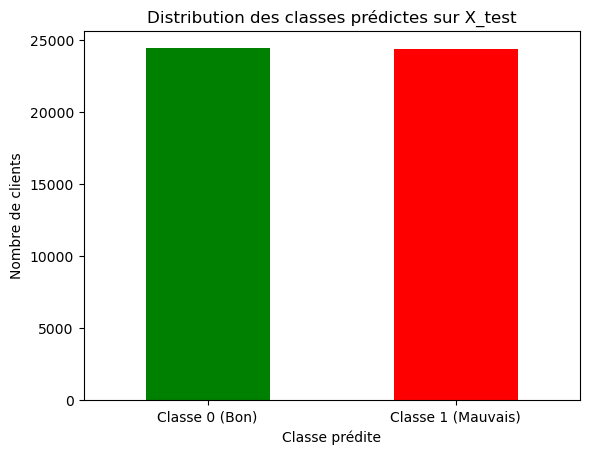

In [33]:
rf_model = ExtraTreesClassifier(max_depth= 10, n_estimators= 200, class_weight='balanced', random_state=42)
rf_model.fit(X, y)

y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

threshold_rf = 0.45
y_test_pred_rf = (y_test_proba_rf >= threshold_rf).astype(int)

# Compter
counts_rf = pd.Series(y_test_pred_rf).value_counts()
print("Nombre de clients classés par le modèle :")
print(counts_rf)

# Visualisation rapide
counts_rf.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution des classes prédictes sur X_test')
plt.xlabel('Classe prédite')
plt.ylabel('Nombre de clients')
plt.xticks(ticks=[0, 1], labels=["Classe 0 (Bon)", "Classe 1 (Mauvais)"], rotation=0)
plt.show()


#### LogisticRegression

C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nombre de clients classés par le modèle :
0    31371
1    17373
Name: count, dtype: int64


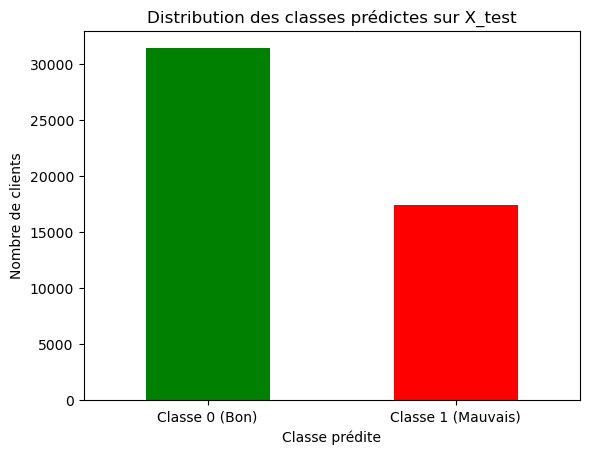

In [35]:
lr_model = LogisticRegression(C= 1, penalty= 'l2', max_iter=500, class_weight='balanced', random_state=42)
lr_model.fit(X, y)

y_test_proba_lr = lr_model.predict_proba(X_test)[:,1]
threshold_lr = 0.50
y_test_pred_lr = (y_test_proba_lr >= threshold_lr).astype(int)

# Compter
counts_lr = pd.Series(y_test_pred_lr).value_counts()
print("Nombre de clients classés par le modèle :")
print(counts_lr)

# Visualisation rapide
counts_lr.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution des classes prédictes sur X_test')
plt.xlabel('Classe prédite')
plt.ylabel('Nombre de clients')
plt.xticks(ticks=[0, 1], labels=["Classe 0 (Bon)", "Classe 1 (Mauvais)"], rotation=0)
plt.show()

In [36]:
# Liste des modèles pour boucler ensuite
models = {
    "LightGBM": final_model,
    "ExtraTreesClassifier": rf_model,
    "Logistic Regression": lr_model
}

## **Feature Importance**

### **Globale**

**SHAP**:
- Calcule pour chaque feature combien elle contribue à augmenter ou baisser la prédiction du modèle
- Plus performant avec des dataframe volumineuse comme ici


🔎 Calcul SHAP pour LightGBM


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


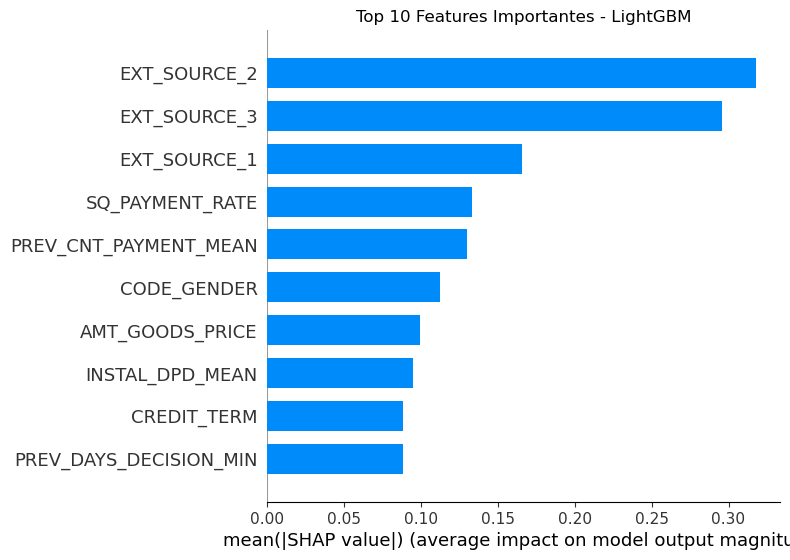

In [40]:
# Fonction générique pour SHAP global

def shap_summary(model, model_name):
    print(f"🔎 Calcul SHAP pour {model_name}")

    # Initialiser l'explainer
    explainer = shap.TreeExplainer(model) if model_name != "Logistic Regression" else shap.Explainer(model, X_test)
    
    # Calculer les valeurs SHAP
    shap_values = explainer.shap_values(X_test)
    
    # Pour classifier, shap_values est une liste [0] classe 0, [1] classe 1
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # On prend la classe 1 (mauvais client)

    # Summary Plot complet
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=10, color_bar=True, cmap="viridis",show=False)
    plt.title(f"Top 10 Features Importantes - {model_name}")
    plt.show()

shap_summary(final_model, "LightGBM")

In [41]:
shap_summary(rf_model, "ExtraTreesClassifier")

🔎 Calcul SHAP pour ExtraTreesClassifier



KeyboardInterrupt



In [ ]:
shap_summary(lr_model, "Logistic Regression")

### **Locale**

In [48]:
# Choisir un client au hasard
indice_client = 10 
print(f"Client sélectionné : {indice_client}")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)


# Waterfall plot pour ce client
shap.plots.waterfall(shap.Explanation(values=shap_values[1][indice_client],
                                      base_values=explainer.expected_value[1],
                                      data=X.iloc[indice_client]))

Client sélectionné : 10


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


IndexError: invalid index to scalar variable.

In [ ]:
# Choisir un client au hasard

print(f"Client sélectionné : {indice_client}")
indice_client_1 = 50 
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)


# Waterfall plot pour ce client
shap.plots.waterfall(shap.Explanation(values=shap_values[1][indice_client_1],
                                      base_values=explainer.expected_value[1],
                                      data=X.iloc[indice_client_1]))